In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from ocpaper231.plotutils import Plot
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
from torch_geometric.utils import index_to_mask
from torch_geometric.data import Data
import scienceplots
from gnn_tracking.utils.loading import TrackingDataModule
import numpy as np


plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from ocpaper231.names import variable_manager as vm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/"
        ],
        stop=10,
    ),
)
dm.setup(stage="fit")

[13:43:42] INFO: DataLoader will load 719 graphs (out of 719 available).
[13:43:42] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21999_s0.pt
[13:43:42] INFO: DataLoader will load 10 graphs (out of 801 available).
[13:43:42] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29009_s0.pt


In [4]:
from gnn_tracking.utils.lightning import find_latest_checkpoint
from pathlib import Path


model = "chirpy-delicate-jaguarundi"
chkpt_path = find_latest_checkpoint(
    Path(
        f"/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/"
    ),
    model,
)

In [5]:
chkpt_path

PosixPath('/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/chirpy-delicate-jaguarundi/checkpoints/epoch=90-step=698400.ckpt')

In [6]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location="cpu")

[13:43:43] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[13:43:43] DEBUG: Getting class PotentialLoss from module gnn_tracking.metrics.losses
[13:43:43] DEBUG: Getting class BackgroundLoss from module gnn_tracking.metrics.losses
[13:43:43] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


# VS EPS

In [36]:
eps = np.linspace(0.0, 1, 80)
ks = [1]  # np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

eps_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)
lmodel.cluster_scanner = eps_scanner

In [43]:
class OrphanRemover:
    def __call__(self, data: Data):
        connected_nodes = data.edge_index.flatten().unique()
        hit_mask = index_to_mask(connected_nodes, size=data.num_nodes)
        ofrac = 1 - hit_mask.sum() / data.num_nodes
        print(f"Removed {ofrac:.2%} of nodes")
        return data.subgraph(hit_mask)

In [44]:
data = dm.datasets["val"][0]

In [45]:
data

Data(x=[59357, 14], edge_index=[2, 95591], edge_attr=[95591, 4], y=[95591], pt=[59357], particle_id=[59357], reconstructable=[59357], sector=[59357], evtid=[1], s=[1], eta=[59357], ec_score=[95591])

In [46]:
OrphanRemover()(data)

Removed 36.95% of nodes


Data(x=[37424, 14], edge_index=[2, 95591], edge_attr=[95591, 4], y=[95591], pt=[37424], particle_id=[37424], reconstructable=[37424], sector=[37424], evtid=[1], s=[1], eta=[37424], ec_score=[95591])

In [47]:
ModelSummary(lmodel)

  | Name            | Type                 | Params
---------------------------------------------------------
0 | model           | PreTrainedECGraphTCN | 1.9 M 
1 | potential_loss  | PotentialLoss        | 0     
2 | background_loss | BackgroundLoss       | 0     
---------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.579     Total estimated model params size (MB)

In [48]:
trainer = Trainer(accelerator="cpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[12:56:18] INFO: DataLoader will load 10 graphs (out of 801 available).
[12:56:18] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29009_s0.pt
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

In [ ]:
class TracksVsDBSCANPlot(Plot):
    def __init__(self, mean_df: pd.DataFrame, **kwargs):
        super().__init__(**kwargs)
        self.df = mean_df.sort_values("eps")
        self.ax.set_xlabel(r"DBSCAN $\varepsilon$")
        self.ax.set_ylabel("Metric")

    def plot_var(self, var, k=1, **kwargs):
        line, *_ = self.ax.errorbar(
            "eps",
            var,
            label=vm[var].latex,
            yerr=f"{var}_std",
            data=self.df[self.df["min_samples"] == k],
            # marker="o",
            **kwargs,
        )

In [ ]:
from pathlib import Path

tvdp = TracksVsDBSCANPlot(
    mean_df=eps_scanner.get_results().df_mean,
    # model=model,
    # watermark="outdated",
)
tvdp.plot_var("double_majority_pt0.9")
tvdp.plot_var("lhc_pt0.9")
tvdp.plot_var("perfect_pt0.9")
tvdp.ax.legend()
tvdp.ax.axhline(0.977064, color="C0", ls=":")
tvdp.ax.axhline(0.7907116988303107, color="C0", ls=":")
tvdp.ax.axhline(0.920599, color="C2", ls=":")
tvdp.ax.axhline(0.417143, color="C2", ls=":")
tvdp.ax.get_figure().savefig("performance_vs_eps.pdf")

In [ ]:
tvdp.df["double_majority_pt0.9"].max()

In [1]:
tvdp.df["perfect_pt0.9"].max()

NameError: name 'tvdp' is not defined

In [19]:
df = tvdp.df
r = df.query("(`double_majority_pt0.9` > 0.9) & (min_samples == 1)")[
    ["eps", "double_majority_pt0.9"]
]
r

,eps,double_majority_pt0.9
4,0.111538,0.903718
5,0.136923,0.921044
6,0.162308,0.933125
7,0.187692,0.940753
8,0.213077,0.945495
9,0.238462,0.948407
10,0.263846,0.950337
11,0.289231,0.951092
12,0.314615,0.949621
13,0.340000,0.947149



# vs pt and eta

In [44]:
class PerformancePlot(Plot):
    def __init__(self, xs, df, *, df_ul=None, var="pt", **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.df_ul = df_ul
        self.xs = xs
        self.ax.set_xlabel(vm[var])
        self.ax.set_ylabel("Efficiency")
        self._legend_items = []

    def plot_var(
        self,
        var,
        color,
        *,
        label=None,
        plot_ul=True,
    ):
        stairs = self.ax.stairs(var, edges=self.xs, data=self.df, color=color, lw=1.5)
        if self.df_ul is not None and plot_ul:
            self.ax.stairs(
                var, edges=self.xs, data=self.df_ul, color=color, lw=1.5, ls=":"
            )
        mids = (self.xs[:-1] + self.xs[1:]) / 2
        if label is None:
            label = vm[var].latex
        bar = self.ax.errorbar(
            mids,
            var,
            yerr=f"{var}_std",
            ls="none",
            color=color,
            data=self.df,
            capsize=3,
        )
        self._legend_items.append(((stairs, bar), label))

    def add_blocked(self, a, b, label="Not trained for"):
        self.ax.axvspan(a, b, alpha=0.3, color="gray", label=label, linestyle="none")

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)

## Upper bound

In [7]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_data,
    tracking_metric_df,
)
from gnn_tracking.analysis.graphs import get_cc_labels
import pandas as pd


def get_truth_hc_dfs(dm):
    h_dfs = []
    c_dfs = []
    for data in dm.val_dataloader():
        y = data.y.bool()
        ei = data.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        h_df = pd.DataFrame(
            {
                "c": labels,
                "id": data.particle_id,
                "pt": data.pt,
                "reconstructable": data.reconstructable,
                "eta": data.eta,
            }
        )
        c_df = tracking_metric_df(h_df)
        h_dfs.append(h_df)
        c_dfs.append(c_df)
    return h_dfs, c_dfs

In [8]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_pt


h_dfs, c_dfs = get_truth_hc_dfs(dm)

In [9]:
import numpy as np

pts = np.array(np.arange(0, 3, 0.3).tolist() + [5.0])

In [10]:
vs_pt_ul = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)

In [24]:
vs_pt_ul

,n_particles,n_cleaned_clusters,perfect,double_majority,lhc,fake_perfect,fake_double_majority,fake_lhc,n_particles_std,n_cleaned_clusters_std,perfect_std,double_majority_std,lhc_std,fake_perfect_std,fake_double_majority_std,fake_lhc_std,pt_min,pt_max
0,2118.5,199.0,0.014151,0.046852,1.0,0.079586,0.046885,0.0,157.094628,28.382311,0.002754,0.004125,0.0,0.008530,0.007496,0.0,0.0,0.3
1,2954.2,1049.0,0.115386,0.258172,1.0,0.239711,0.096925,0.0,268.958402,99.308722,0.005298,0.008522,0.0,0.011032,0.006724,0.0,0.3,0.6
2,1322.1,1016.5,0.488217,0.715185,1.0,0.280741,0.053774,0.0,144.736120,111.410402,0.017711,0.014074,0.0,0.016387,0.005939,0.0,0.6,0.9
3,600.4,598.5,0.910135,0.970916,1.0,0.087027,0.026246,0.0,56.004365,53.672360,0.015153,0.006914,0.0,0.018239,0.007496,0.0,0.9,1.2
4,309.0,310.0,0.926058,0.981506,1.0,0.077237,0.021789,0.0,28.095077,28.142495,0.009684,0.005483,0.0,0.013578,0.008020,0.0,1.2,1.5
5,185.5,187.2,0.930837,0.985383,1.0,0.078090,0.023543,0.0,18.644332,19.245779,0.022174,0.008734,0.0,0.024664,0.010431,0.0,1.5,1.8
6,102.6,102.4,0.938673,0.984917,1.0,0.060078,0.013834,0.0,8.113090,7.183314,0.018802,0.014787,0.0,0.017466,0.013554,0.0,1.8,2.1
7,64.8,65.0,0.934201,0.990923,1.0,0.067762,0.011040,0.0,11.754904,12.192894,0.037266,0.016551,0.0,0.026444,0.013151,0.0,2.1,2.4
8,42.1,42.1,0.926886,0.975503,1.0,0.073417,0.024799,0.0,10.181137,10.060373,0.030699,0.026039,0.0,0.039577,0.032194,0.0,2.4,2.7
9,79.7,80.3,0.922780,0.987133,1.0,0.084051,0.019697,0.0,7.717944,8.353974,0.023891,0.010790,0.0,0.024606,0.012807,0.0,2.7,5.0


In [11]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta

etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])

In [12]:
etas

array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
       -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
        0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
        2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ,
        4.        ])

In [13]:
vs_eta_ul = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

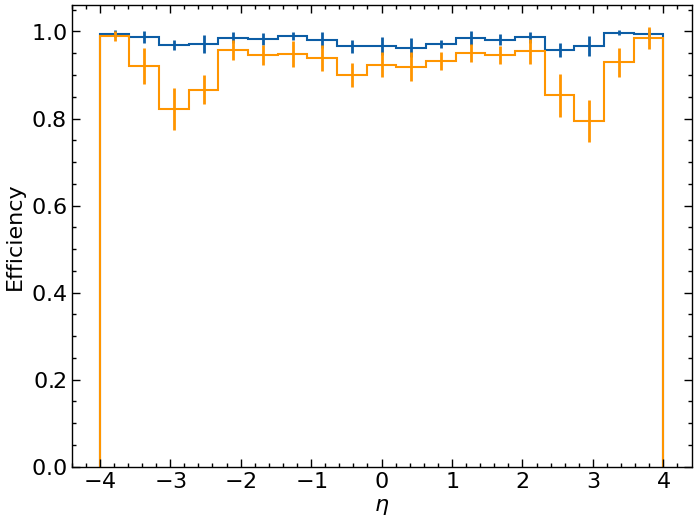

In [16]:
p = PerformancePlot(df=vs_eta_ul, xs=etas, var=vm["eta"].latex)  # , model=model)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)

In [17]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta

vs_eta_ul = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

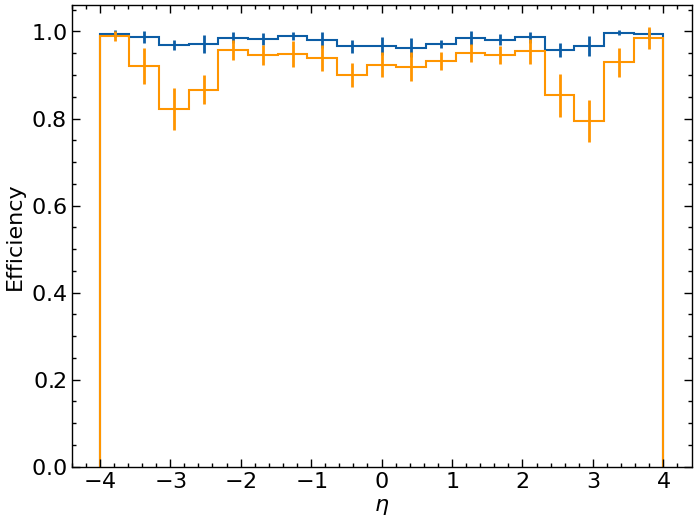

In [18]:
p = PerformancePlot(df=vs_eta_ul, xs=etas, var=vm["eta"].latex)  # , model=model)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)


## Actual performance

In [19]:
# eyeballed
best_eps = 0.270526
best_k = 1

In [39]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

detail_scanner = DBSCANPerformanceDetails(eps=best_eps, min_samples=best_k)
lmodel.cluster_scanner = detail_scanner

trainer = Trainer(accelerator="cpu")
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[14:04:27] INFO: DataLoader will load 10 graphs (out of 801 available).
[14:04:27] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9

Validation: 0it [00:00, ?it/s]

In [40]:
h_dfs, c_dfs = detail_scanner.get_results()

In [25]:
import pickle

with Path("h_dfs.pkl").open("wb") as f:
    pickle.dump(h_dfs, f)
with Path("c_dfs.pkl").open("wb") as f:
    pickle.dump(c_dfs, f)

In [41]:
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

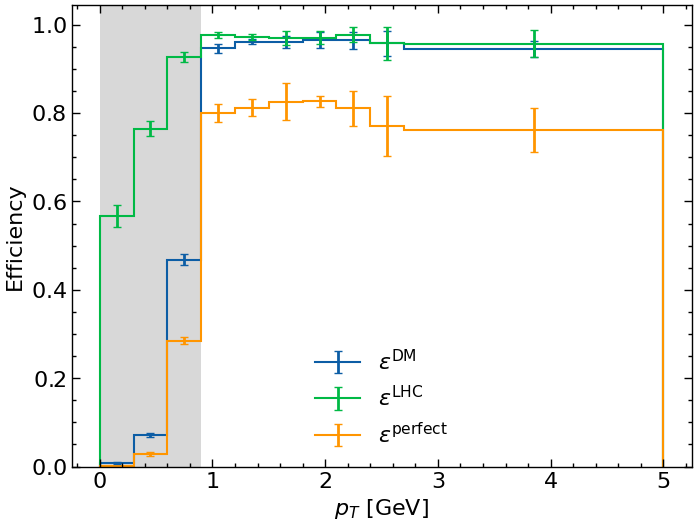

In [45]:
p = PerformancePlot(
    df=vs_pt, df_ul=None, xs=pts, var=vm["pt"].latex + " [GeV]"
)  # , model=model)
p.add_blocked(0, 0.9)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_legend()
p.ax.get_figure().savefig("vs_pt.pdf")

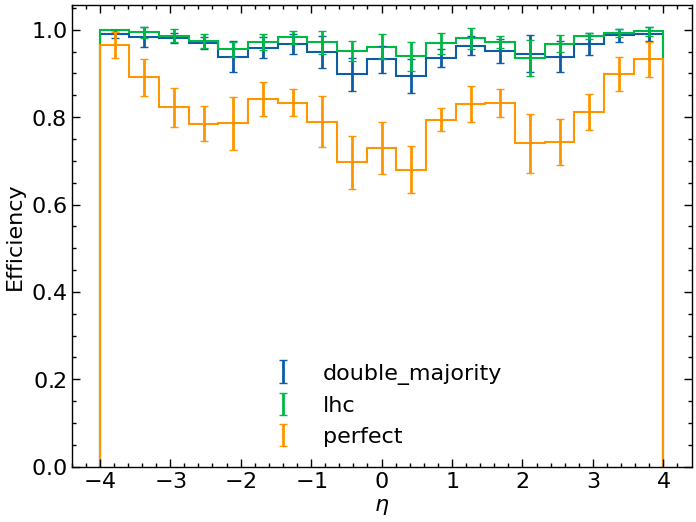

In [46]:
# vs_eta_ul = None
p = PerformancePlot(
    df=vs_eta, df_ul=None, xs=etas, var=vm["eta"].latex
)  # , model=model
# p.ax.set_xlim(-4.5, 4.5)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("lhc", "C1", label=vm["lhc_pt0.9"].latex, plot_ul=False)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)
p.ax.legend()
p.ax.get_figure().savefig("vs_eta.pdf")

In [42]:
vm["double_majority"].latex

'$\\epsilon^{\\mathrm{DM}}$'

In [82]:
class PerformanceComparisonPlot(Plot):
    def __init__(self, xs, var, x_label, **kwargs):
        super().__init__(**kwargs)
        self.xs = xs
        self.var = var
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel("Efficiency")
        self._legend_items = []

    def plot_var(self, df, label, color):
        stairs = self.ax.stairs(df[self.var], edges=self.xs, color=color, lw=1.5)
        mids = (self.xs[:-1] + self.xs[1:]) / 2
        bar = self.ax.errorbar(
            mids,
            self.var,
            yerr=f"{self.var}_std",
            ls="none",
            color=color,
            data=df,
            capsize=3,
        )
        self._legend_items.append(((stairs, bar), label))

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)

In [64]:
vs_eta_ul

,n_particles,n_cleaned_clusters,perfect,double_majority,lhc,fake_perfect,fake_double_majority,fake_lhc,n_particles_std,n_cleaned_clusters_std,perfect_std,double_majority_std,lhc_std,fake_perfect_std,fake_double_majority_std,fake_lhc_std,eta_min,eta_max
0,55.3,55.1,0.989798,0.995024,1.0,0.006839,0.001613,0.0,7.761014,7.651434,0.011671,0.008017,0.0,0.011705,0.005100,0.0,-4.000000,-3.578947
1,57.5,57.5,0.919668,0.988476,1.0,0.081391,0.012583,0.0,5.930149,5.275731,0.041260,0.013809,0.0,0.042893,0.012267,0.0,-3.578947,-3.157895
2,64.9,72.6,0.820942,0.968303,1.0,0.298947,0.151585,0.0,11.656662,12.624491,0.048449,0.011355,0.0,0.074524,0.035184,0.0,-3.157895,-2.736842
3,69.7,73.0,0.866669,0.971224,1.0,0.179469,0.074914,0.0,9.393260,10.488088,0.033548,0.021578,0.0,0.049937,0.033127,0.0,-2.736842,-2.315789
4,75.9,74.8,0.957016,0.985910,1.0,0.028894,0.000000,0.0,11.159948,10.891383,0.023086,0.011901,0.0,0.021919,0.000000,0.0,-2.315789,-1.894737
5,83.5,82.1,0.945993,0.982960,1.0,0.038066,0.001099,0.0,14.033690,13.494443,0.024027,0.014025,0.0,0.017268,0.003475,0.0,-1.894737,-1.473684
6,87.1,86.2,0.947577,0.990017,1.0,0.042440,0.000000,0.0,15.044010,14.710540,0.030279,0.009228,0.0,0.027632,0.000000,0.0,-1.473684,-1.052632
7,82.7,81.4,0.939531,0.980907,1.0,0.044678,0.003302,0.0,9.888826,9.968840,0.029307,0.018349,0.0,0.029180,0.007176,0.0,-1.052632,-0.631579
8,89.7,86.8,0.899861,0.965834,1.0,0.067122,0.001149,0.0,12.009718,12.172829,0.028184,0.015048,0.0,0.028325,0.003635,0.0,-0.631579,-0.210526
9,84.2,81.6,0.923925,0.966673,1.0,0.043823,0.001075,0.0,11.063453,11.862171,0.029338,0.021720,0.0,0.025923,0.003400,0.0,-0.210526,0.210526


In [65]:
etas.shape

(21,)

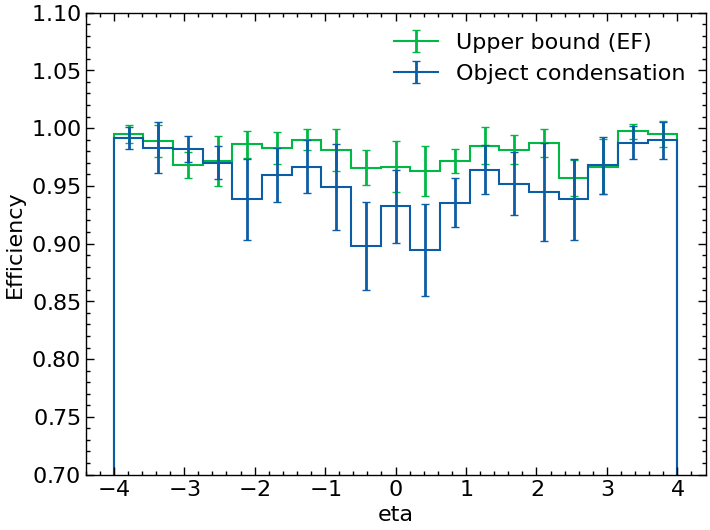

In [83]:
p = PerformanceComparisonPlot(xs=etas, var="double_majority", x_label=vm["eta"])
p.ax.set_ylim(0.7, 1.1)
# p.plot_var(df, label="Upper bound (graph construction)", color="C0")
p.plot_var(vs_eta_ul, label="Upper bound (EF)", color="C1")
# p.plot_var(vs_eta_ul, label="Connected components (EF)", color="C1")
p.plot_var(vs_eta, label="Object condensation", color="C0")
p.add_legend()
p.ax.get_figure().savefig("vs_eta_dm.pdf")